In [ ]:
# !pip install cloud-tpu-client==0.10 torch==1.11.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl

### Importing liabraries

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from collections import Counter
import torch
import torch.nn as nn
from torch.utils import data
from torchvision import datasets
from torchvision import transforms
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
BASE_PATH = r"/content/drive/MyDrive/Sem_4/NLP_HW_1/nlp2022-hw1-main"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_Text(lines, count):
    count = count
    initial_char = lines[count]
    Text = []
    Text.append(initial_char.strip().split("\t"))

    count +=1
    initial_char = lines[count]

    while initial_char.startswith("#") == False:
        count +=1
        Text.append(initial_char.strip().split("\t"))
        initial_char = lines[count]
    return Text, count

In [ ]:
def get_df(filename , type_of_data) :  
    f = open(os.path.join(BASE_PATH, f"data/{filename}"))
    lines = f.readlines()
    length_of_file = len(lines)
    if type_of_data == "train":
        Text = []
        Tag = []
        Id = []
        count = 0
        while count < length_of_file:
            try :
                text, count = get_Text(lines, count)
                Id.append(int(text[0][-1]))
                Text.append([i[0] for i in text[1:-1]])
                Tag.append([i[1] for i in text[1:-1]])
            except:
                break

        df = pd.DataFrame(columns = ["Id", "Tag", "Text"])
        df["Id"]  = Id
        df["Tag"] = Tag
        df["Text"] = Text
    elif type_of_data == "test":
        Text = []
        Id = []
        count = 0
        while count < length_of_file:
            try :
                text, count = get_Text(lines, count)
                Id.append(int(text[0][-1]))
                Text.append([i[0] for i in text[1:-1]])
            except:
                break

        df = pd.DataFrame(columns = ["Id", "Text"])
        df["Id"]  = Id
        df["Text"] = Text
    
    return df

In [ ]:
filename = "train.tsv"
df_train = get_df("train.tsv",  "train")
df_dev = get_df("dev.tsv",  "train")

In [ ]:
df_train.head()

,Id,Tag,Text
0,0,"[O, O, O, O, O, O, B-LOC, O, O, O, O, O, O, O,...","[it, lies, approximately, north, east, of, bol..."
1,1,"[B-CW, I-CW, I-CW, I-CW, I-CW, I-CW, I-CW, I-C...","[does, anybody, really, know, what, time, it, ..."
2,2,"[B-PER, I-PER, O, B-PER, I-PER, O, B-PER, I-PE...","[amrish, puri, ,, anupam, kher, ,, mukesh, kha..."
3,3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[wilds, himself, later, said, that, he, was, c..."
4,4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[he, scored, the, first, goal, of, a, famous, ..."


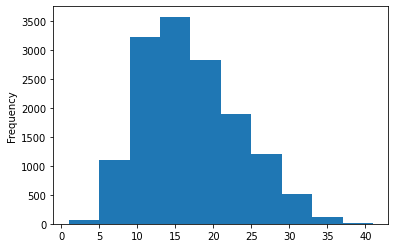

In [ ]:
df_train["Text"].map(len).plot(kind = "hist")

In [ ]:
def get_vocab(Text: list ):
    vocab = []
    for sentence in tqdm(Text):
        for word in sentence:
            vocab.append(word)
    vocab = Counter(vocab)
    return vocab

def word_to_id(vocab, unknown):
    word_to_id_dict = {}
    
    count = 0
    for word in vocab:
        word_to_id_dict[word] = count
        count = count +1
    word_to_id_dict[unknown] = count
    return word_to_id_dict

vocab_word_count_dict = get_vocab(df_train["Text"].to_list())
vocab = list(set(list(vocab_word_count_dict.keys())))

# tag_count_dict = get_vocab(df_train["Tag"].to_list())
# tag = list(set(list(tag_count_dict.keys())))

unknown_word = "<UNK>"
# unknown_tag = "<UNK_Tag>"

word_to_id_dict = word_to_id(vocab, unknown_word)
id_to_word_dict = dict((value, key)  for key , value in word_to_id_dict.items())

# tag_to_id_dict = word_to_id(tag, unknown_tag)
# id_to_tag_dict = dict((value, key)  for key , value in tag_to_id_dict.items())


# tag_to_ix = word_to_id(tag, unknown_tag)
word_to_ix = word_to_id(vocab, unknown_word)

In [ ]:
import json
# with open(BASE_PATH + "/data/word_to_ix.json", "w", encoding ='utf8') as f:
#     json.dump(word_to_ix, f)

In [ ]:
with open(BASE_PATH + "/data/word_to_ix.json", "r", encoding ='utf8') as f:
    word_to_ix = json.load(f)

with open(BASE_PATH + "/data/tag_to_ix.json", "r", encoding ='utf8') as f:
    tag_to_ix = json.load(f)

In [ ]:
# class_weights = compute_class_weight(class_weight="balanced", classes= list(tag_to_ix.keys()), y=[j for i in df_train["Tag"] for j in i ])
# np.savetxt(BASE_PATH + "/data/class_weights.txt", class_weights)

In [ ]:
class_weights  = np.loadtxt(BASE_PATH + "/data/class_weights.txt")
class_weights

array([ 6.20664512,  5.20134345,  5.47104274,  4.05284663,  3.62765604,
        6.66598167,  6.18171049,  3.23036551,  3.03497193,  7.10730147,
        3.1808388 , 10.79811066,  0.09575871])

### Model 1- Base model

In [ ]:
training_data = []
for i in range(len(df_train)):
    row = df_train.iloc[i]
    training_data.append((row["Text"], row["Tag"]))

dev_data = []
for i in range(len(df_dev)):
    row = df_dev.iloc[i]
    dev_data.append((row["Text"], row["Tag"]))

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EMBEDDING_DIM = 300
HIDDEN_DIM = 20

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,  num_layers= 2, dropout=0.2)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
torch.Tensor(class_weights).to(device)
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix)).to(device)
loss_function = nn.NLLLoss(weight = torch.Tensor(class_weights).to(device))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
Lossses_list =[]
for epoch in range(5):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in tqdm(training_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        sentence_in =sentence_in.to(device)
        targets =targets.to(device)

        # Step 3. Run our forward pass.
        
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        Lossses_list.append(loss)

100%|██████████| 14534/14534 [01:33<00:00, 154.82it/s]


In [ ]:
from sklearn.metrics import classification_report
def predict(indices):    
    for index in range(len(indices)):
        with torch.no_grad():
            inputs = prepare_sequence(dev_data[index][0], word_to_ix)
            inputs = inputs.to(device)
            tag_scores = model(inputs)
        values, target = torch.max(tag_scores, 1)
        target = np.array(target.to('cpu'))
        yield target

def accuracy_score(y_true, y_pred):
    y_pred = np.concatenate(tuple(y_pred))
    y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(y_pred.shape)
    return (y_true == y_pred).sum() / float(len(y_true))

y_pred = list(predict([s for s, t in dev_data]))
y_true = [t for s, t in dev_data]

y_true_indexed = []
for tag in y_true:
    tag_lst=[]
    for i in tag:
        tag_lst.append(tag_to_ix[i])

    y_true_indexed.append(tag_lst)
y_true = y_true_indexed

tag_lst=[]
for tag in y_true:

    for i in tag:
        tag_lst.append(i)

tag_lst_pred=[]
for tag in y_pred:

    for i in tag:
        tag_lst_pred.append(i)

report = classification_report(tag_lst, tag_lst_pred, target_names=tag_to_ix.keys())
print(report)

              precision    recall  f1-score   support

      B-CORP       0.54      0.48      0.51       119
        B-CW       0.22      0.34      0.26       133
       B-GRP       0.78      0.59      0.67       376
       B-LOC       0.36      0.23      0.28       149
       B-PER       0.66      0.31      0.42       189
      B-PROD       0.62      0.75      0.68       329
      I-CORP       0.51      0.59      0.55       243
        I-CW       0.21      0.04      0.06       170
       I-GRP       0.70      0.33      0.45       153
       I-LOC       0.91      0.97      0.94     10230
       I-PER       0.26      0.24      0.25       261
      I-PROD       0.50      0.49      0.50        87
           O       0.89      0.08      0.15       300

    accuracy                           0.86     12739
   macro avg       0.55      0.42      0.44     12739
weighted avg       0.85      0.86      0.84     12739



In [ ]:
l = [i.detach().to("cpu").numpy() for i in Lossses_list]
z = []
for i in range(5):
    z.append(l[i*14534])
import plotly.express as px

fig = px.line(z ,title='Losses with epochs')
fig.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Sem_4/NLP_HW_1/nlp2022-hw1-main/model_1")

### Functions for model

In [ ]:
# !wget https://nlp.stanford.edu/data/glove.6B.zip -P /content/drive/MyDrive/Sem_4/glove_model/
# !unzip /content/drive/MyDrive/Sem_4/glove_model/glove*.zip -d /content/drive/MyDrive/Sem_4/glove_model/

--2022-04-09 21:41:59--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-09 21:41:59--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/content/drive/MyDrive/Sem_4/glove_model/glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 40s  

2022-04-09 21:44:39 (5.13 MB/s) - ‘/content/drive/MyDrive/Sem_4/glove_model/glove.6B.zip’ saved [862182613/862182613]

Archive:  /content/drive/MyDri

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Let's read file, to understand word embedding
def get_embedding_dict(embedding_path):
    embedding_vectot_dict= {}
    with open(os.path.join("/content/drive/MyDrive/Sem_4/", embedding_path),"r", encoding= "utf8") as f:
        for line in tqdm(f.readlines()):
            word, *vector = line.split()
            embedding_vectot_dict[word] = np.array(vector, "float32")
    return embedding_vectot_dict

def get_embedding_matrix(embedding_path_50):
    embedding_dict = get_embedding_dict(embedding_path_50)
    embedding_matrix = []
    for idx, word in enumerate(word_to_ix.keys()):
        try :
            embedding_matrix.append(embedding_dict[word])  
        except:
            embedding_matrix.append(np.random.normal(scale=0.5, size=(EMBEDDING_DIM, )).tolist())
    embedding_matrix = np.array(embedding_matrix)
    return embedding_matrix

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        try:
            idxs.append(to_ix[w])
        except:
            idxs.append(to_ix[unknown_word])
    return torch.tensor(idxs, dtype=torch.long)

def get_flatten_tensor_to_calculate_loss(tag_scores, target):
    mask = target>=0
    mask = mask.to(device)
    tag_scores = tag_scores.view(-1,13)[ mask.view(-1)]

    actual_target = target.view(-1,1)[ mask.view(-1,1)]
    one_hot_encod_class = torch.nn.functional.one_hot(actual_target, 13).to(device)
    return  tag_scores, one_hot_encod_class

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, training_data, word_to_ix, tag_to_ix):
        self.training_data = training_data
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix

    def __len__(self):
        return len(self.training_data)

    def __getitem__(self, idx):
        data = self.training_data[idx]
        sentence= data[0]
        tags=  data[1]
        sentence_in = prepare_sequence(sentence, self.word_to_ix)
        targets = prepare_sequence(tags, self.tag_to_ix)

        return sentence_in, targets

def get_actual_and_prediction(tag_scores,  target):
    mask = target>=0
    mask = mask.to(device)
    tag_scores = tag_scores.view(-1,13)[ mask.view(-1)]
    actual_target = target.view(-1,1)[ mask.view(-1,1)]
    prediction = tag_scores.max(1)[1]
    actual_target.to(device)

    return prediction, actual_target
    
def get_model_prediction_actual(dataset_ds):
    prediction_list = []
    actual_list = [] 
    model.eval()
    with torch.no_grad():
        for ii in dataset_ds: 
    
            sentence_in = ii[0]
            target = ii[1]

            sentence_in = pad_sequence(sentence_in, batch_first=True, padding_value=word_to_ix["<UNK>"])
            target = pad_sequence(target, batch_first=True, padding_value=-1)

            sentence_in = sentence_in.to(device)
            target_label = target.to(device)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            prediction, actual_target = get_actual_and_prediction(tag_scores,  target_label)
            prediction = np.array(prediction.to("cpu"))
            actual_target = np.array(actual_target.to("cpu"))

            for p, a in zip(prediction, actual_target):
                prediction_list.append(p)
                actual_list.append(a) 
    
    model.train()

    return prediction_list, actual_list

In [ ]:
def calculate_F1_Score(dataset):
    prediction_list, actual_list = get_model_prediction_actual(dataset)
    report = classification_report(actual_list, prediction_list, target_names=tag_to_ix.keys(),output_dict=True)
    return format(report["macro avg"]["f1-score"], ".4f")

## Model 2- With dice loss

In [ ]:
training_data = []
for i in range(len(df_train)):
    row = df_train.iloc[i]
    training_data.append((row["Text"], row["Tag"]))

dev_data = []
for i in range(len(df_dev)):
    row = df_dev.iloc[i]
    dev_data.append((row["Text"], row["Tag"]))

In [ ]:

# EMBEDDING_DIM = 300
# embedding_path_50 = f"glove_model/glove.6B.{EMBEDDING_DIM}d.txt"
# embedding_matrix = get_embedding_matrix(embedding_path_50)


100%|██████████| 400000/400000 [00:31<00:00, 12734.03it/s]


In [ ]:
# np.savetxt(BASE_PATH + "/data/embedding_matrix.txt", embedding_matrix)

embedding_matrix = np.loadtxt(BASE_PATH + "/data/embedding_matrix.txt")

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, embedding_matrix, dense_layer_neurons):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
       
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_embeddings.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.word_embeddings.requires_grad_ = False
        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,  num_layers=2, dropout = 0.1, bidirectional = True , batch_first = True)
        # The linear layer that maps from hidden state space to tag space

        # self.dense = nn.Linear(2*hidden_dim, dense_layer_neurons)

        # self.hidden2tag = nn.Linear( dense_layer_neurons, tagset_size)

        self.hidden2tag = nn.Linear( 2*hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        # dense = self.dense(lstm_out)
        # tag_space = self.hidden2tag(dense)

        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
# class_weights = torch.Tensor(class_weights).to(device)

In [ ]:
hyper_parameters = {"EMBEDDING_DIM":300, 
                    "HIDDEN_DIM" :    400,
                    "BATCH_SIZE" :    32,
                    "dense_layer_neurons" : 26,
                    "learning_rate":0.001, "num_layers":2, "dropout" : 0.2, "epochs" :70} 

EMBEDDING_DIM = hyper_parameters["EMBEDDING_DIM"]
HIDDEN_DIM = hyper_parameters["HIDDEN_DIM"]
batch_size = hyper_parameters["BATCH_SIZE"]
dense_layer_neurons = hyper_parameters["dense_layer_neurons"]
learning_rate = hyper_parameters["learning_rate"]
num_layers = hyper_parameters["num_layers"]
dropout =  hyper_parameters["dropout"]
epochs = hyper_parameters["epochs"]

import json
with open(BASE_PATH + "/hyperparameters.json", "+a", encoding ='utf8') as f:
    json.dump(hyper_parameters, f)

# class_weights = torch.Tensor(class_weights).to(device)

In [ ]:
train_ds_custom = CustomImageDataset(training_data, word_to_ix, tag_to_ix)
train_ds = DataLoader(train_ds_custom, batch_size=batch_size, shuffle=True, collate_fn=lambda x: list(zip(*x)) )

dev_ds_custom = CustomImageDataset(dev_data, word_to_ix, tag_to_ix)
dev_ds = DataLoader(dev_ds_custom, batch_size=batch_size, collate_fn=lambda x: list(zip(*x)) )

In [ ]:
# model.eval()
# with torch.no_grad():
#     for ii in train_ds: 

#         sentence_in = ii[0]
#         target = ii[1]

#         sentence_in = pad_sequence(sentence_in, batch_first=True, padding_value=word_to_ix["<UNK>"])
#         target = pad_sequence(target, batch_first=True, padding_value=-1)

#         sentence_in = sentence_in.to(device)
#         target = target.to(device)

#         # Step 3. Run our forward pass.
#         tag_scores = model(sentence_in)
#         scores, one_hot_encod_class = get_flatten_tensor_to_calculate_loss(tag_scores, target)
#         break
# model.train()

In [ ]:
import math
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
        self.eps :float = 1e-6 

    def forward(self, scores, one_hot_encod_class):
        intersection =torch.sum(scores * one_hot_encod_class)
        union = torch.sum(scores + one_hot_encod_class)
        
        dice_loss = 1 - 2*intersection/(union + self.eps)
        return dice_loss

    def forward_2(self, scores, one_hot_encod_class):
        p_y = torch.sum(scores*one_hot_encod_class )
        lambda_ = 1

        p_y_square = torch.sum(torch.square(scores))
        y_square = torch.sum(one_hot_encod_class )

        loss = 1 - (2*p_y + lambda_)/(p_y_square+ y_square +  lambda_)
        return loss 

class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, scores, one_hot_encod_class):

        return -torch.sum( one_hot_encod_class * torch.log(scores.view(-1,13)))/len(scores.view(-1,13))

class JaccardCoefitient(nn.Module):
    def __init__(self, eps = 1) -> None:
        super(JaccardCoefitient, self).__init__()
        self.eps = 1

    def forward(self, scores, one_hot_encod_class, class_weight= None):
        if torch.is_tensor(class_weight) == True:
            intersection =torch.sum(torch.sum(scores * one_hot_encod_class) * class_weight) + self.eps
            union = torch.sum(torch.sum(scores)*class_weight+ torch.sum(one_hot_encod_class)) - intersection  + self.eps  
            return intersection/union  
        else:
            intersection =torch.sum(scores * one_hot_encod_class) + self.eps
            union = torch.sum(scores)+ torch.sum(one_hot_encod_class) - intersection  + self.eps  
            return intersection/union 

class FocalLoss(nn.Module):
    def __init__(self, alpha = 0.5, gamma = 2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma # From the paper , they sai dthat oit works best for them for gamma is 2
        self.alpha = alpha

    def forward(self, scores, one_hot_encod_class, class_weight= None):
        modulating_factor = torch.pow((1- scores),  self.gamma)
        log_scores = torch.log(scores)
        # return torch.sum(-class_weights * modulating_factor * log_scores , dim =1)
        return torch.mean(torch.sum(-self.alpha * modulating_factor * log_scores , dim =1))

class TwerkyLoss(nn.Module):
    def __init__(self, alpha = 0.5, beta= 0.7):
        super(TwerkyLoss, self).__init__()
        self.alpha =alpha
        self.eps = 1e-6
        self.beta = beta

    def forward(self, scores , one_hot_encod_class):
        
        intersection = torch.sum(scores * one_hot_encod_class, 1)
        fps = torch.sum(scores * (1. - one_hot_encod_class), 1)
        fns = torch.sum((1. - scores) * one_hot_encod_class, 1)

        numerator = intersection
        denominator = intersection + self.alpha * fps + self.beta * fns
        tversky_loss = numerator / (denominator + self.eps)

        return torch.mean(1. - tversky_loss)

diceloss = DiceLoss()
crossentropyloss = CrossEntropyLoss()
jaccardcoefitient = JaccardCoefitient()
focalloss = FocalLoss()
twerkyloss = TwerkyLoss()


In [ ]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), 
                   len(tag_to_ix), embedding_matrix, dense_layer_neurons).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# optimizer= optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 50], gamma=0.5)

In [ ]:
Lossses_list =[]
train_F1_score = []
dev_F1_score = []
count_epoch = 0

In [ ]:
from sklearn.metrics import classification_report, accuracy_score as AC

unknown_word = "<UNK>"
for epoch in range(epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_sum = 0
    for ii in train_ds:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance

        model.zero_grad()

        sentence_in = ii[0]
        target = ii[1]
    
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        # sentence_in = prepare_sequence(sentence, word_to_ix)
        # targets = prepare_sequence(tags, tag_to_ix)


        sentence_in = pad_sequence(sentence_in, batch_first=True, padding_value=word_to_ix["<UNK>"])
        target = pad_sequence(target, batch_first=True, padding_value=-1)
        
        
        sentence_in =sentence_in.to(device)
        target = target.to(device)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        scores, one_hot_encod_class = get_flatten_tensor_to_calculate_loss(tag_scores, target)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # loss = CustomLogLikelyhoodLoss(tag_scores, target, class_weights)

        ## 1) Diceloss
        # loss = diceloss.forward(scores, one_hot_encod_class)
        # loss = diceloss.forward_2(scores, one_hot_encod_class)

        ## 3) Cross entropy Loss
        # loss = crossentropyloss(scores, one_hot_encod_class)

        ## 4) Diceloss +  CrossentropyLoss
        # loss = diceloss.forward(scores, one_hot_encod_class) + crossentropyloss.forward(scores, one_hot_encod_class)
        # loss = diceloss.forward_2(scores, one_hot_encod_class) + crossentropyloss.forward(scores, one_hot_encod_class)

        ## 3) JaccardCoefitient
        # loss = jaccardcoefitient.forward(scores, one_hot_encod_class, class_weights)
        # loss = jaccardcoefitient.forward(scores, one_hot_encod_class, class_weight=class_weights)

        ## 4) Focal Loss
        # loss = focalloss(scores, one_hot_encod_class)

        ## 5) Twerky Lossù

        loss = twerkyloss(scores, one_hot_encod_class) 

        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_sum = loss_sum + loss
        
        # print(accuracy_score)
    
    d_f1_score = calculate_F1_Score(dev_ds)
    t_f1_score = calculate_F1_Score(train_ds)
    count_epoch +=1 
    print("Train Loss is ", loss_sum.item(), f"with f1 score, train {t_f1_score}  dev {d_f1_score} ",  " at epoch ", count_epoch )
    dev_F1_score.append(d_f1_score)
    train_F1_score.append(t_f1_score)
    Lossses_list.append(loss_sum)

Train Loss is  398.92236328125 with f1 score, train 0.2364  dev 0.1999   at epoch  1
Train Loss is  383.56781005859375 with f1 score, train 0.4301  dev 0.3490   at epoch  2
Train Loss is  375.3397216796875 with f1 score, train 0.4872  dev 0.3616   at epoch  3
Train Loss is  370.0382385253906 with f1 score, train 0.5681  dev 0.3912   at epoch  4
Train Loss is  366.2223815917969 with f1 score, train 0.6039  dev 0.4010   at epoch  5
Train Loss is  363.9497375488281 with f1 score, train 0.6159  dev 0.4139   at epoch  6
Train Loss is  362.5957336425781 with f1 score, train 0.6294  dev 0.4074   at epoch  7
Train Loss is  361.47515869140625 with f1 score, train 0.6465  dev 0.4235   at epoch  8
Train Loss is  360.7033996582031 with f1 score, train 0.6580  dev 0.4348   at epoch  9
Train Loss is  360.0280456542969 with f1 score, train 0.6676  dev 0.4300   at epoch  10
Train Loss is  359.54669189453125 with f1 score, train 0.6753  dev 0.4263   at epoch  11
Train Loss is  359.14501953125 with f1 s

In [ ]:
loss_list = np.array([i.detach().to("cpu").item() for i in tqdm(Lossses_list)])
NewMax =100
NewMin = 0
OldMax = max(loss_list)
OldMin= min(loss_list)
OldRange = (OldMax - OldMin)  
NewRange = (NewMax - NewMin)  

def getnew_value(OldValue):
    NewValue = (((OldValue - OldMin) * NewRange) / OldRange) + NewMin
    return NewValue

l_list = [getnew_value(i) for i in loss_list.tolist()]

100%|██████████| 70/70 [00:00<00:00, 32399.17it/s]


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()

# l = [i.detach().to("cpu").item() for i in tqdm(Lossses_list)]

train_F1_score_ = [float(i)*100 for i in train_F1_score]
dev_F1_score_ = [float(i)*100 for i in dev_F1_score]
fig.add_trace(go.Scatter(x=np.arange(0, len(Lossses_list)), y=l_list,
                    mode='lines+markers',
                    name='Loss'))

fig.add_trace(go.Scatter(x=np.arange(0, len(Lossses_list)), y=train_F1_score_ ,
                    mode='lines+markers',
                    name='train_F1_score'))

fig.add_trace(go.Scatter(x=np.arange(0, len(Lossses_list)), y=dev_F1_score_,
                    mode='lines+markers',
                    name='dev_F1_score'))

fig.update_layout(
    title="Twerky Loss",
    xaxis_title="Epochs",
    yaxis_title="Loss F1 Score",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",

        color="RebeccaPurple"
    )
)
fig.show()

In [ ]:
min(loss_list), max(train_F1_score_), max(dev_F1_score_)

(356.08160400390625, 82.57, 51.43)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()

# l = [i.detach().to("cpu").item() for i in tqdm(Lossses_list)]

# train_F1_score_ = [float(i)*100 for i in train_F1_score]
# dev_F1_score_ = [float(i)*100 for i in dev_F1_score]
fig.add_trace(go.Scatter(x=np.arange(0, len(Lossses_list)), y=loss_list,
                    mode='lines+markers',
                    name='Loss'))

fig.update_layout(
    title="Twerky Loss",
    xaxis_title="Epochs",
    yaxis_title="Loss",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",

        color="RebeccaPurple"
    )
)
fig.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Sem_4/NLP_HW_1/nlp2022-hw1-main/Twerky_1.pt")

In [ ]:
torch.save(model, "/content/drive/MyDrive/Sem_4/NLP_HW_1/nlp2022-hw1-main/model_33.pt")

### References  
1. [Pytorch Sequence model tutorial](#https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html)  
2. https://arxiv.org/pdf/1911.02855.pdf  
3. [Focal Loss Paper](#https://arxiv.org/pdf/1708.02002.pdf)